![nflverse downloads](../images/nfl.png)

#### Goal

Feature Selection:  build features for a play-level model that evaluates the potential a play call (e.g. pass, rush, field goal, etc)  based on the situation and team stats

 - The independent values consist of situations such as drive, down, yards to go seconds reaminign in the game, etc.

- The dependent or "Y" features are simply whether the game was won or lost = WIN/LOSS

- The goal is just to identify the indicators that we'll want to use for subsequent models - this is not an end in itself



#### Input

- nfl_ml_weekly_stats.parquet

#### Steps:

- Extract performance data

- convert ints to float

- measure correlation against the WIN/LOSS target

- Classify important features from XGBoost

- Classify weights from a shallow neural net

- review that they are all in agreement and pick the best from each analysis

- Use SHAP to get the relative weights (importance) for each feature

- Manually separate stats that are offense-related and those that are defence related - for any given drive the offense and defense flip. and we want to be able to provide the stats for whichever team is on offense vs the stats for the opposing team

- take the weighted average of each feature * its weights from SHAP - sum them all up to get a

- this produces a **power_scores** dataset with single offense_power score and defense_power score for each team, for each season and week

- query a version of the **play_actions** table from the database that we'll use to input for a play calling model

- merge the **power_scores** and **play_actions** datasets, so we have the correct offense and defense 'powers' scored for each play, depending on which team is offense and defense.

#### Output

- pbp_actions.parquet
- defense_power.parquet
- offense_power.parquet


# imports

In [1]:
import os
import sys

sys.path.append(os.path.abspath("../src"))

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import warnings

warnings.filterwarnings('ignore')


In [3]:
from src import *

# set flags

In [4]:
db = database_loader.DatabaseLoader(get_config('connection_string'))
DEBUG = False
SCHEMA = 'controls'

file_name = "nfl_pbp_game_stats"
data_directory = get_config('data_directory')

input_path = os.path.join(data_directory, f"{file_name}.parquet")
assert os.path.exists(input_path)

# plt.style.use('ggplot')
plt.style.use('seaborn-darkgrid')


# load the NFL stats dataset

In [5]:
weekly_stats_df = pd.read_parquet(input_path)
stats_df = weekly_stats_df.drop(columns=['team'])
stats_df.head()

,season,week,game_id,opposing_team,team_offense_power,team_defense_power,opposing_team_offense_power,opposing_team_defense_power,point_spread,drive_count,...,field_goal_attempt,two_point_attempt,extra_point_attempt,timeout,penalty,qb_spike,loss_tie_win,team_power_sum,opposing_team_power_sum,power_difference
0,2016,1,2016_01_BUF_BAL,BUF,23.428697,5.476946,17.649834,6.353670,6.0,68,...,2.0,0.0,1.0,1.0,1.0,0.0,2,28.905643,24.003503,4.902140
1,2016,1,2016_01_BUF_BAL,BAL,17.649834,6.353670,23.428697,5.476946,-6.0,50,...,1.0,0.0,1.0,1.0,1.0,0.0,0,24.003503,28.905643,-4.902140
2,2016,1,2016_01_CAR_DEN,DEN,22.940911,5.430129,17.864515,6.617459,-1.0,73,...,3.0,0.0,2.0,0.0,2.0,2.0,0,28.371039,24.481975,3.889065
3,2016,1,2016_01_CAR_DEN,CAR,17.864515,6.617459,22.940911,5.430129,1.0,60,...,0.0,0.0,3.0,0.0,1.0,0.0,2,24.481975,28.371039,-3.889065
4,2016,1,2016_01_CHI_HOU,HOU,22.804072,8.374514,29.423198,6.710474,-9.0,56,...,0.0,0.0,2.0,0.0,0.0,0.0,0,31.178586,36.133672,-4.955087


# perform feature selection

In [6]:
keep_columns = [
    # 'season',
    # 'week',
    # 'game_id',
    'drive_count',
    'first_downs',
    'yards_gained',
    'pass_attempts',
    'rush_attempts',
    # 'kickoff_attempt',
    # 'punt_attempt',
    'field_goal_attempt', 'two_point_attempt',
    'extra_point_attempt',
    # 'timeout', 'penalty',
    'qb_spike',
    'power_difference',
    'loss_tie_win'
]


df = stats_df[keep_columns]
df['loss_tie_win'] = np.where(df['loss_tie_win']!=2, 0, 1 )

df.head()

,drive_count,first_downs,yards_gained,pass_attempts,rush_attempts,field_goal_attempt,two_point_attempt,extra_point_attempt,qb_spike,power_difference,loss_tie_win
0,68,26,308.0,37.0,28.0,2.0,0.0,1.0,0.0,4.902140,1
1,50,18,160.0,24.0,24.0,1.0,0.0,1.0,0.0,-4.902140,0
2,73,29,333.0,36.0,32.0,3.0,0.0,2.0,2.0,3.889065,0
3,60,29,307.0,28.0,29.0,0.0,0.0,3.0,0.0,-3.889065,1
4,56,23,258.0,34.0,20.0,0.0,0.0,2.0,0.0,-4.955087,0


## prepare our data for feature selection
We'll have an X, and y set plus the original stats_df datasets, which we'll use going forward

In [7]:
assert 0 == df.isnull().sum().sum()


## define helper functions

In [8]:

X = df.copy()
y = X.pop('loss_tie_win')

X.head()

,drive_count,first_downs,yards_gained,pass_attempts,rush_attempts,field_goal_attempt,two_point_attempt,extra_point_attempt,qb_spike,power_difference
0,68,26,308.0,37.0,28.0,2.0,0.0,1.0,0.0,4.902140
1,50,18,160.0,24.0,24.0,1.0,0.0,1.0,0.0,-4.902140
2,73,29,333.0,36.0,32.0,3.0,0.0,2.0,2.0,3.889065
3,60,29,307.0,28.0,29.0,0.0,0.0,3.0,0.0,-3.889065
4,56,23,258.0,34.0,20.0,0.0,0.0,2.0,0.0,-4.955087


In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features = scaler.fit_transform(X.to_numpy())
X = pd.DataFrame(features, columns=X.columns)
X.head()

,drive_count,first_downs,yards_gained,pass_attempts,rush_attempts,field_goal_attempt,two_point_attempt,extra_point_attempt,qb_spike,power_difference
0,0.483871,0.37500,0.437919,0.492754,0.469388,0.250,0.0,0.111111,0.0,0.633757
1,0.193548,0.12500,0.189597,0.304348,0.387755,0.125,0.0,0.111111,0.0,0.366243
2,0.564516,0.46875,0.479866,0.478261,0.551020,0.375,0.0,0.222222,0.5,0.606115
3,0.354839,0.46875,0.436242,0.362319,0.489796,0.000,0.0,0.333333,0.0,0.393885
4,0.290323,0.28125,0.354027,0.449275,0.306122,0.000,0.0,0.222222,0.0,0.364798


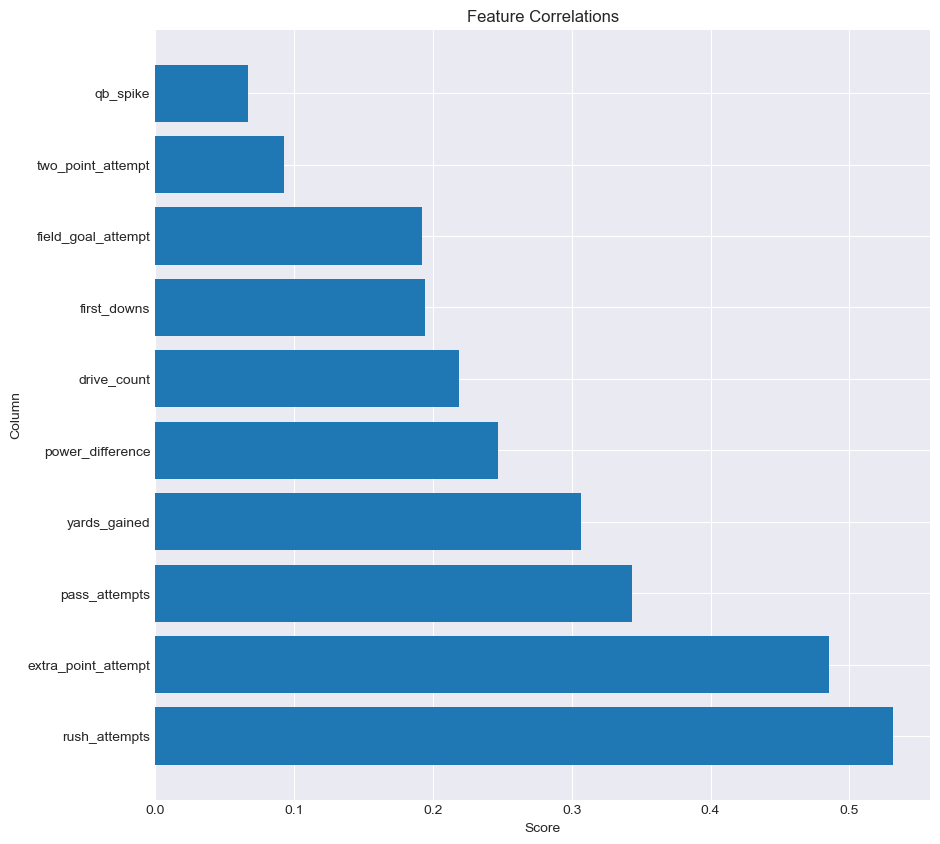

In [10]:
from src.utils_eda import correlate_to_target, plot_correlations

top_correlations, set_correlations = correlate_to_target(df, 'loss_tie_win', 30)
plot_correlations(top_correlations['corr'], top_correlations['y'], 'Feature Correlations')

## get cross correlations

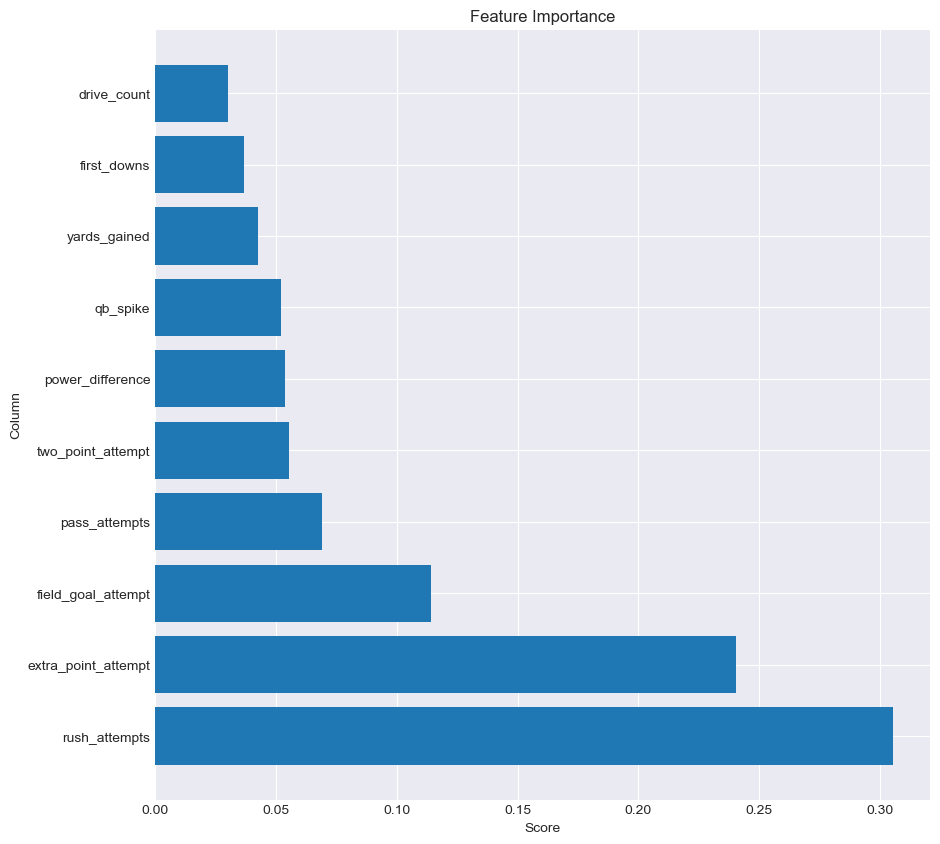

In [11]:
from src.utils_eda import calc_feature_importance

top_features, set_features = calc_feature_importance(X, y, top_n=30)
plot_correlations(top_features['corr'], top_features['y'], "Feature Importance")

In [12]:
from keras.src.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
# Convert labels to one-hot encoded format

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y)
encoded_labels = to_categorical(encoded_labels)


X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.15, random_state=42)


In [13]:
from src.build_power_scores import create_shallow_model

model, r = create_shallow_model(X_train, y_train,
                                         epochs_size=200,
                                         batch_size=64,
                                         learning_rate=.0005,
                                         activation_function="relu",
                                         output_function="sigmoid",
                                         loss_function='binary_crossentropy')


2023-07-18 19:23:18.575510: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-07-18 19:23:18.575529: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-07-18 19:23:18.575532: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-07-18 19:23:18.575560: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-18 19:23:18.575573: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/200


2023-07-18 19:23:19.046324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - 1s 14ms/step - loss: 5.1500 - accuracy: 0.5442 - val_loss: 4.2889 - val_accuracy: 0.7191
Epoch 2/200
 8/46 [====>.........................] - ETA: 0s - loss: 4.1661 - accuracy: 0.7305

2023-07-18 19:23:19.766656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - 0s 9ms/step - loss: 3.5566 - accuracy: 0.7891 - val_loss: 2.8709 - val_accuracy: 0.7315
Epoch 3/200
46/46 [==============================] - 0s 9ms/step - loss: 2.3314 - accuracy: 0.8093 - val_loss: 1.9171 - val_accuracy: 0.8025
Epoch 4/200
46/46 [==============================] - 0s 10ms/step - loss: 1.5822 - accuracy: 0.8035 - val_loss: 1.3212 - val_accuracy: 0.7747
Epoch 5/200
46/46 [==============================] - 0s 9ms/step - loss: 1.0907 - accuracy: 0.8148 - val_loss: 0.9943 - val_accuracy: 0.7778
Epoch 6/200
46/46 [==============================] - 0s 9ms/step - loss: 0.8411 - accuracy: 0.8117 - val_loss: 0.8100 - val_accuracy: 0.7809
Epoch 7/200
46/46 [==============================] - 0s 9ms/step - loss: 0.7225 - accuracy: 0.8104 - val_loss: 0.7259 - val_accuracy: 0.7747
Epoch 8/200
46/46 [==============================] - 0s 9ms/step - loss: 0.6695 - accuracy: 0.8049 - val_loss: 0.6822 - val_accuracy: 0.8025
Epoch 9/200
46/46 [=====

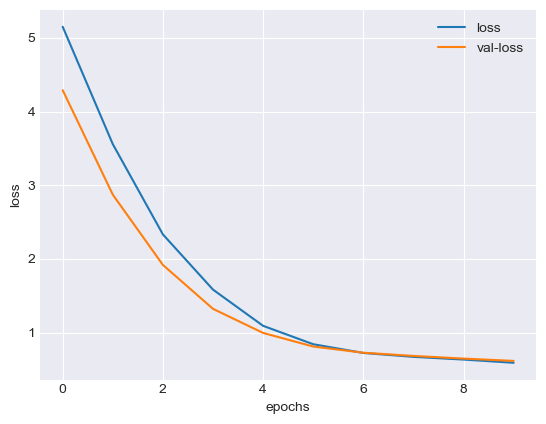

In [14]:
from src.utils_eda import plot_loss

plot_loss(r)

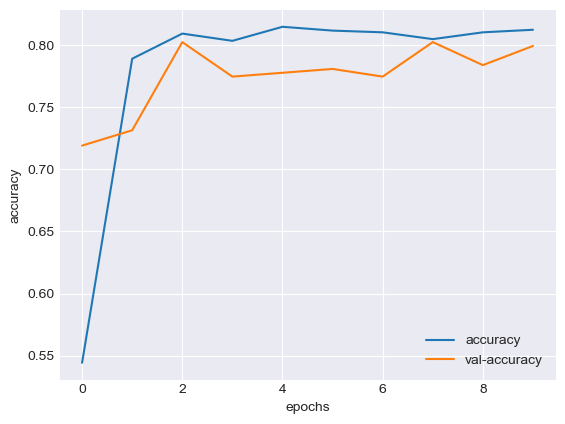

In [15]:
from src.utils_eda import plot_accuracy

plot_accuracy(r)

In [16]:

y_pred_probs = model.predict(X_test)
y_pred_binary = (y_pred_probs[:, 1] >= 0.5).astype(int)
y_test = (y_test[:, 1] >= 0.5).astype(int)


18/18 [==============================] - 0s 2ms/step


2023-07-18 19:23:23.794861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [17]:
from src.utils_eda import plot_confusion_matrix, print_f1_scores
from sklearn.metrics import roc_auc_score

print_f1_scores(y_pred_binary, y_test)

# Assuming you have y_actual and y_predicted for binary classification
auc = roc_auc_score(y_test, y_pred_binary)
print("AUC:    ", auc)


Precision: 0.8043478260869565
Recall: 0.8409090909090909
F1-score: 0.8222222222222223
AUC:     0.8327922077922078


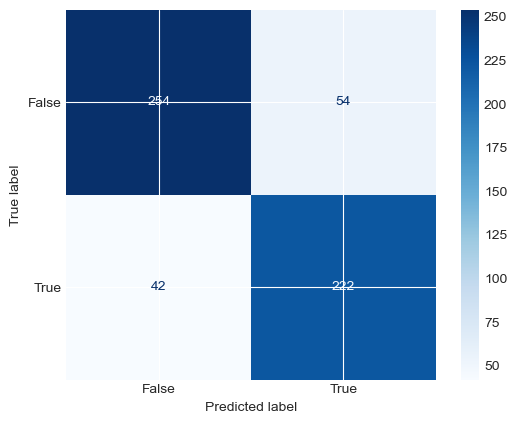

In [18]:
plot_confusion_matrix(y_pred_binary, y_test)

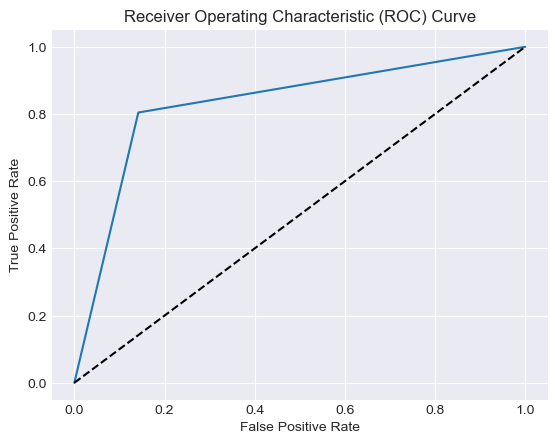

In [19]:
from src.util_keras import plot_roc_curve

plot_roc_curve(y_pred_binary, y_test)

## create xy dataset slicesCorr()

2023-07-18 19:23:24.300629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-18 19:23:47.557805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


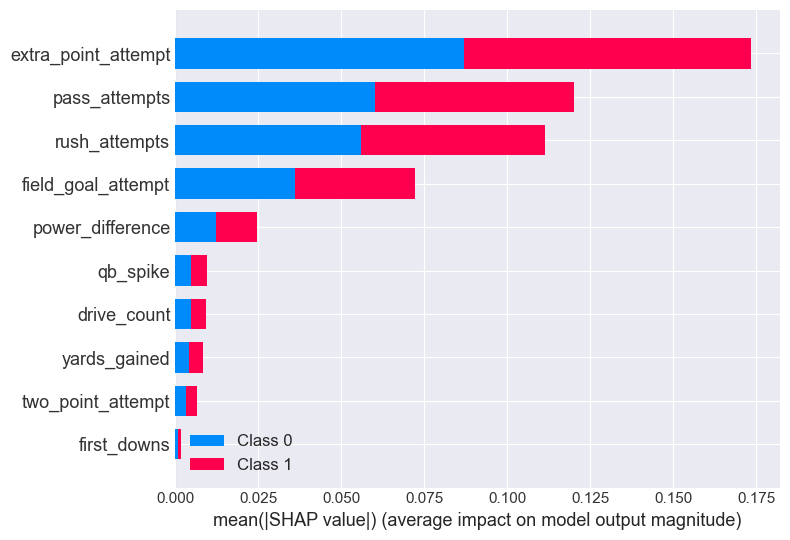

In [20]:
import shap

# Assuming you have a trained Keras model 'model' and a dataset 'X'
explainer = shap.DeepExplainer(model, data=X_train.values)
shap_values = explainer.shap_values(X_train.values)

shap_values_df = pd.DataFrame(shap_values[0], columns=X_train.columns)

# Calculate the mean absolute SHAP values and standard deviations
summary_data = pd.DataFrame({
    'Feature': X_train.columns,
    'Mean': np.abs(shap_values_df).mean(axis=0)
})

# Plotting the SHAP values with column names
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)